In [2]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt

from transparent_background import Remover

from IPython.display import clear_output
clear_output()

In [6]:
DATA_DIR = os.path.join('..', '.data', 'roboflow')
PROCESSED_DIR = os.path.join('..', 'data', 'cropped_pcbs')
MANUAL_INSPECTION_DIR = os.path.join('..', 'data', 'manual_inspection')

In [3]:
with open(os.path.join(DATA_DIR, 'data.yaml'), 'r') as f:
    metadata = yaml.safe_load(f)
classes = metadata['names']
print(f"Number of classes: {len(classes)}")

Number of classes: 23


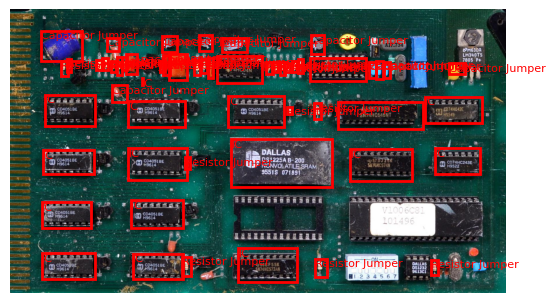

In [4]:
train_images = os.listdir(os.path.join(DATA_DIR, 'train', 'images'))
image = train_images[4]
label = image.split('.jpg')[0] + '.txt'

image = plt.imread(os.path.join(DATA_DIR, 'train', 'images', image))
plt.imshow(image)
plt.axis('off')

width, height = image.shape[1], image.shape[0]

with open(os.path.join(DATA_DIR, 'train', 'labels', label), 'r') as f:
    for line in f:
        cl, x, y, w, h = map(float, line.strip().split())
        x1 = (x - w / 2) * width
        y1 = (y - h / 2) * height
        
        class_name = classes[int(cl)]
        # draw bounding box
        plt.gca().add_patch(plt.Rectangle((x1, y1), w * width, h * height,
                                            edgecolor='red', facecolor='none', linewidth=2))
        plt.text(x1, y1, class_name, color='red', fontsize=8, verticalalignment='top')

plt.show()

In [9]:
def find_least_rotated_image(images: list[np.ndarray]) -> tuple[np.ndarray, int]:
    least_rotated_img = 0
    least_black_pixels = float('inf')
    for i, img in enumerate(images):
        num_black_pixels = np.sum(img == 0)
        if num_black_pixels < least_black_pixels:
            least_black_pixels = num_black_pixels
            least_rotated_img = i
    return images[least_rotated_img], least_rotated_img

PCB ID: pcb41rec1_jpg, Number of images: 4


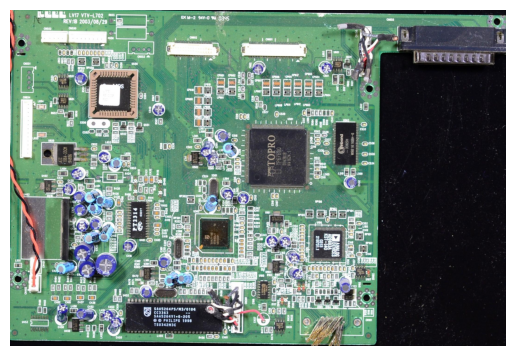

In [32]:
pcbs = {t.split('.rf')[0]: [i for i in train_images if i.startswith(t.split('.rf')[0])] for t in train_images}
pcb = list(pcbs.items())[0]
pcb_id, images = pcb
print(f"PCB ID: {pcb_id}, Number of images: {len(images)}")
imgs = [plt.imread(os.path.join(DATA_DIR, 'train', 'images', img)) for img in images]
least_rotated_img = find_least_rotated_image(imgs)[0]
plt.imshow(least_rotated_img)
plt.axis('off')
plt.show()

Settings -> Mode=base, Device=mps:0, Torchscript=disabled


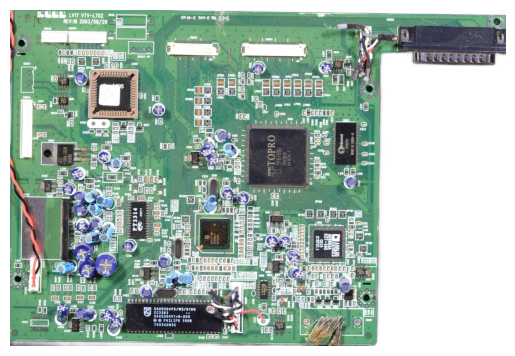

In [33]:
remover = Remover()
out = remover.process(least_rotated_img)
plt.imshow(out)
plt.axis('off')
plt.show()

In [8]:
train = set(t.split('.rf')[0] for t in os.listdir(os.path.join(os.path.join(DATA_DIR, 'train'), 'images')))
test = set(t.split('.rf')[0] for t in os.listdir(os.path.join(os.path.join(DATA_DIR, 'test'), 'images')))
valid = set(t.split('.rf')[0] for t in os.listdir(os.path.join(os.path.join(DATA_DIR, 'valid'), 'images')))

# make sure there is no overlap between train, test and valid sets
assert len(train & test) == 0, "Overlap between train and test sets"
assert len(train & valid) == 0, "Overlap between train and valid sets"
assert len(test & valid) == 0, "Overlap between test and valid sets"

In [ ]:
for split in ['train', 'valid', 'test']:
    split_dir = os.path.join(DATA_DIR, split)
    split_images = os.listdir(os.path.join(split_dir, 'images'))
    pcbs = {t.split('.rf')[0]: [i for i in split_images if i.startswith(t.split('.rf')[0])] for t in split_images}
    for pcb in pcbs.items():
        pcb_id, images = pcb
        imgs = [plt.imread(os.path.join(split_dir, 'images', img)) for img in images]

        # Find the least rotated image and save it
        least_rotated_img, ix = find_least_rotated_image(imgs)
        out = remover.process(least_rotated_img)
        output_path = os.path.join(PROCESSED_DIR, f"{pcb_id}.png")
        plt.imsave(output_path, out)

        # # Copy the corresponding label file to the processed directory
        # label_path = os.path.join(split_dir, 'labels', images[ix].replace('.jpg', '.txt'))
        # with open(label_path, 'r') as f:
        #     label_data = f.readlines()
        # with open(os.path.join(PROCESSED_DIR, f"{pcb_id}.txt"), 'w') as f:
        #     f.writelines(label_data)

In [36]:
# check how many pcbs were processed
processed_files = os.listdir(PROCESSED_DIR)
print(f"Number of processed pcbs: {len(processed_files)}")

Number of processed pcbs: 199


Manually delete ones that did not work

In [37]:
# check how many pcbs are left
processed_files = os.listdir(PROCESSED_DIR)
print(f"Number of processed pcbs: {len(processed_files)}")

Number of processed pcbs: 72


In [10]:
if not os.path.exists(MANUAL_INSPECTION_DIR):
    os.makedirs(MANUAL_INSPECTION_DIR)
for split in ['train', 'valid', 'test']:
    split_dir = os.path.join(DATA_DIR, split)
    split_images = os.listdir(os.path.join(split_dir, 'images'))
    pcbs = {t.split('.rf')[0]: [i for i in split_images if i.startswith(t.split('.rf')[0])] for t in split_images}
    for pcb in pcbs.items():
        pcb_id, images = pcb
        if f"{pcb_id}.png" not in processed_files:
            imgs = [plt.imread(os.path.join(split_dir, 'images', img)) for img in images]
            least_rotated_img, ix = find_least_rotated_image(imgs)
            output_path = os.path.join(MANUAL_INSPECTION_DIR, f"{pcb_id}.png")
            plt.imsave(output_path, least_rotated_img)

Manually fix the ones that can be fixed and move them to the PROCESS_DIR folder

In [11]:
# check how many pcbs are finally processed
processed_files = os.listdir(PROCESSED_DIR)
print(f"Number of processed pcbs: {len(processed_files)}")

Number of processed pcbs: 194


In [293]:
# crop and unwarp the images
import sys
sys.path.append('..')
from scripts.correct4d import unwarp

if not os.path.exists(MANUAL_INSPECTION_DIR):
    os.makedirs(MANUAL_INSPECTION_DIR)
for file in processed_files:
    image = plt.imread(os.path.join(PROCESSED_DIR, file))
    unwarped = unwarp(image)
    plt.imsave(os.path.join(MANUAL_INSPECTION_DIR, file), unwarped)